In [18]:
import numpy as np
import torch
import torchvision
from glob import glob
import os
from datetime import datetime

import src.wnet as wnet

device = 'cuda'

In [19]:
# Construct Dataset
class BSDS500_dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, subset):
        self.root_dir = root_dir
        self.image_paths = glob(os.path.join(root_dir, 'BSDS500', 'data', 'images', subset, '*.jpg'))
        self.image_sizes = [np.take(torchvision.io.read_image(img_path).shape, [1,2]) for img_path in self.image_paths]
        self.image_size = (224, 224)
        
        self.max_image = None
        self.min_image = None
        for i in range(self.__len__()):
            image = torchvision.io.read_image(self.image_paths[i]).float()
            image = torchvision.transforms.functional.resize(image, self.image_size, interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR)
            self.max_image = torch.max(self.max_image, image) if self.max_image is not None else image
            self.min_image = torch.min(self.min_image, image) if self.min_image is not None else image

    def __len__(self):
        return len(self.image_paths)

    def size(self, idx=None):
        s = [self.__len__(), 3, self.image_size[0], self.image_size[1]]
        if idx is not None:
            s = s[idx]
        else:
            s = torch.Size(s)
        return s

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = torchvision.io.read_image(img_path)
        image = image.float()
        image = torchvision.transforms.functional.resize(image, self.image_size, interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR)
        image = (image - self.min_image) / (self.max_image - self.min_image)
        return image.to(device)

class BSDS500():
    def __init__(self, root_dir, batch_size):
        self.trainset = BSDS500_dataset(root_dir, 'train')
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=batch_size, shuffle=True)
        self.valset = BSDS500_dataset(root_dir, 'val')
        self.valloader = torch.utils.data.DataLoader(self.valset, batch_size=batch_size, shuffle=False)
        self.testset = BSDS500_dataset(root_dir, 'test')
        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=batch_size, shuffle=False)

    def get_trainloader(self):
        return self.trainloader
    
    def get_valloader(self):
        return self.valloader

    def get_testloader(self):
        return self.testloader

if device == "mps":
    batch_size = 16
else:
    batch_size = 8

dataset = BSDS500('../BSDS500', batch_size)
X_train = dataset.get_trainloader()
y_train = dataset.get_trainloader()
X_val = dataset.get_valloader()
y_val = dataset.get_valloader()
X_test = dataset.get_testloader()
y_test = dataset.get_testloader()

EPOCH:      500
Train loss: 1.2586E-02
Valid loss: 1.2592E-02


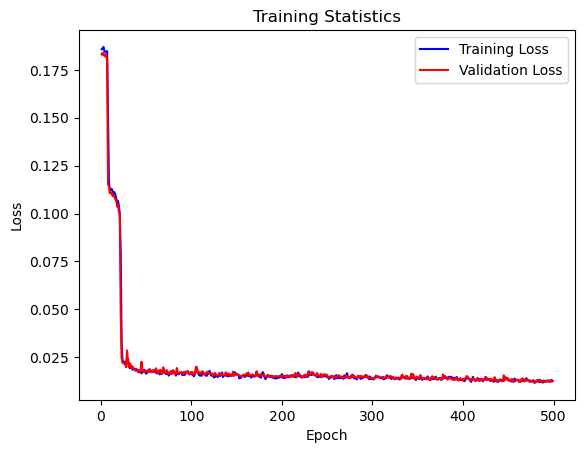

In [25]:
from importlib import reload
import src.wnet as wnet
import src.network as network
import src.loss as loss
loss = reload(loss)
network = reload(network)
wnet = reload(wnet)

train = True
epochs = 500
use_checkpoint = False
checkpoint_path = 'models/wnet-2022-11-30-19-52.pt'

net = wnet.WNet(device_type=device)
net.to(device)
if use_checkpoint:
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])
    net.to(device)
    print('Loaded checkpoint from {}'.format(checkpoint_path))

if train:
    net.fit(
        X_train, y_train,
        X_val, y_val,
        epochs=epochs,
        learn_rate=1e-3,
        weight_decay=1e-5
    )
    date = datetime.now().__str__()
    date = date[:16].replace(':', '-').replace(' ', '-')
    torch.save({
                'epoch': epochs,
                'model_state_dict': net.state_dict(),
                }, f'models/wnet-{date}.pt')

In [21]:
import utils.visualize as visualize
from src.crf import crf_fit_predict, crf_batch_fit_predict
import tqdm

all_inputs = []
all_masks = []
all_network_masks = []
for i,batch in tqdm.tqdm(enumerate(X_test)):
  inputs = batch
  mask, outputs = net.forward(inputs)
  inputs = inputs.detach().cpu().numpy()
  outputs = outputs.detach().cpu().numpy()
  mask = mask.detach().cpu().numpy()
  crf_mask = crf_batch_fit_predict(mask, inputs)
  for j in range(inputs.shape[0]):
    all_inputs.append(inputs[j])
    all_network_masks.append(mask[j])
    all_masks.append(crf_mask[j])
    
all_masks = np.array(all_masks)
all_inputs = np.array(all_inputs)
all_network_masks = np.array(all_inputs)

25it [08:05, 19.41s/it]


In [22]:
import skimage
import matplotlib.pyplot as plt

# Convert segmentation mask to RGB with colors averaged from the image
def mask_to_rgb(mask, image):
    mask = mask.argmax(0)
    image = image.transpose(1,2,0)
    mask_rgb = np.zeros(image.shape)
    for i in range(1, mask.max()+1):
        mask_rgb[mask==i] = image[mask==i].mean(0)
    return mask_rgb

# edge detection using sobel filter
def sobel_edge_detection(image):
    image = skimage.color.rgb2gray(image)
    edges = skimage.filters.sobel(image)
    return edges

# segmentation mask to csv
def mask_to_csv(mask):
    mask = mask.argmax(0)
    print(mask)

In [23]:
for i in range(all_masks.shape[0]):
    mask = mask_to_rgb(all_masks[i], all_inputs[i])
    mask = torch.from_numpy(mask).permute(2,0,1)
    id = dataset.testset.image_paths[i].split("/")[-1].split(".")[0]
    mask = torchvision.transforms.functional.resize(mask, list(dataset.testset.image_sizes[i]), interpolation=torchvision.transforms.functional.InterpolationMode.NEAREST)
    torchvision.utils.save_image(mask, f'outputs/png/{id}.png')
    
    # mask = mask_to_rgb(all_masks[i], all_inputs[i])
    mask = (skimage.color.rgb2gray(mask.permute(1,2,0)) * 255).round()
    colors = np.unique(mask)
    for i,color in enumerate(colors):
        mask[mask==color] = i
    np.savetxt(f'outputs/csv/{id}.csv', mask, delimiter=',', fmt='%i')

/tmp/ipykernel_49181/2182552978.py:10: RuntimeWarning: Mean of empty slice.
  mask_rgb[mask==i] = image[mask==i].mean(0)
/home/remote/anaconda3/envs/torch/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [24]:
from evaluation import calculate_mIOU

average_mIOU, max_mIOU = calculate_mIOU("../BSDS500/gt", "outputs/csv")
print("Average (averaged over gt segmentations) mIOU: ", average_mIOU)
print("Max (over gt segmentations) mIOU: ", max_mIOU)

100%|██████████| 200/200 [01:10<00:00,  2.82it/s]

Average (averaged over gt segmentations) mIOU:  0.07700901244076146
Max (over gt segmentations) mIOU:  0.22083159423179524
